In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#other libraries
from tqdm import tqdm
import time
import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from machine_learning import CalorimeterDataset
from resnet import *
from imcal import *

# Simple CNN cluster image classifier

This notebook provides a framework for classifying cluster images from the ATLAS Open Data dataset [ATLAS simulated samples collection for jet reconstruction training](http://opendata.cern.ch/record/15010).
The dataset contains Monte-Carlo simulated samples corresponding to SM hadronic physics processes. As of now (03.20.2022) only the first part of the dataset is used for this analysis. Using the python script in this project 'cut_njets_root.py', the root file is converted into separate files containing 2D histograms. For each number of Truth Jets a category is created, and all the events associated with that number of Truth Jets is placed in the same file for easy access. Data processing is an essential part of any ML process, and this process of creating images is both naive and not necessarily physically motivated. Future work will focus on creating better images, but for now the simple histograms are used for a 'proof-of-concept' version of the code.

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
VAL_PCT = 0.2 #The percentage of the data to be used as the validation set.
N_EVENTS = 1000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.

#N_LABELS = [0, 1, 2] #A list containing the classes of n number of jets we wish to train for
#LABELS = ["black_holes", "ttbar", "sphalerons"]
#FILENAMES = ["black_holes_9996_events_n.h5", "ttbar_13TeV_pTmin1000_10000_events_n.h5", "sphalerons_10000_events_n.h5"]

LABELS = ["ttbar", "directW"]
N_LABELS = [0, 1] #integer labels for the model
FILENAMES = ["ttbar_10000_events.h5", "directW_min300pTHat_10000_events.h5"]


CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
DATAPATH = Path("/disk/atlas3/data_MC/2dhistograms/") #The path to the folder containing the histogram files
RES = 120 #resolution

MODEL_NAME = f'convnet' + str(int(time.time())) #A unique name for the model
print(MODEL_NAME)

"""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
"""
device = torch.device("cpu")

resnet1661778476


In [4]:
def load_hd5_histogram(path:Path):
    """
    Loads the data as numpy array. Opens the file and extracts the data before closing it again.
    """
    with h5py.File(path) as f:
        print (f.keys())
        data = f["images"]
        #create array
        arr = np.array(data)[0:N_EVENTS]
        print(f"Loaded data with {len(arr)} entries of shape {np.shape(arr)}")
        print(f"Check max value: {np.max(arr)}")
        #This is where normalisation happens
        arr[arr>2000] = 2000
        arr = (arr/2000)*255
        return Tensor(arr)

def label_maker(nclasses:list, nevents:int):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
    a = torch.zeros(nevents*len(nclasses), len(nclasses), dtype=torch.int)
    for i in range(len(nclasses)):
        for j in range(nevents):
            a[nevents*i + j][i] = 1
    return a

def load_data(input_files, data_path):
    #Loads the data files
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    data = [load_hd5_histogram(data_path / file) for file in input_files]
    #Partitions off training data
    Cal_train = torch.cat([item[0:train_size] for item in data]).float().to(device)
    labels_train = label_maker(N_LABELS, train_size).float().to(device)
    #Testing data
    Cal_test = torch.cat([item[(train_size):(train_size+val_size)] for item in data]).float().to(device)
    labels_test = label_maker(N_LABELS, val_size).float().to(device)
    #Check everything is ok
    print(f"Data has shape {Cal_test[0].shape}. {len(labels_train)} training images and {len(labels_test)} testing images")
    
    transforms = torchv.transforms.Compose([
        torchv.transforms.RandomHorizontalFlip(),
        torchv.transforms.RandomVerticalFlip()
        #Add random scrolling
        ])

    train_dataset = CalorimeterDataset(Cal_train, labels_train, transform=transforms)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset

### Load the data

Start by loading the data and then taking a look at it.

In [5]:
#load data
traindata, testdata = load_data(FILENAMES, DATAPATH)

<KeysViewHDF5 ['Events', 'Input', 'Resolution', 'images']>
Loaded data with 1000 entries of shape (1000, 120, 120, 3)
Check max value: 1500.2529296875
<KeysViewHDF5 ['Events', 'Input', 'Resolution', 'images']>
Loaded data with 1000 entries of shape (1000, 120, 120, 3)
Check max value: 2020.1082763671875
Data has shape torch.Size([120, 120, 3]). 1600 training images and 400 testing images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0, 0, 0, 0], [1, 1, 1, 1]]
[[9, 73, 92, 57], [284, 253, 272, 209]]
Image shape:  torch.Size([120, 120, 3])


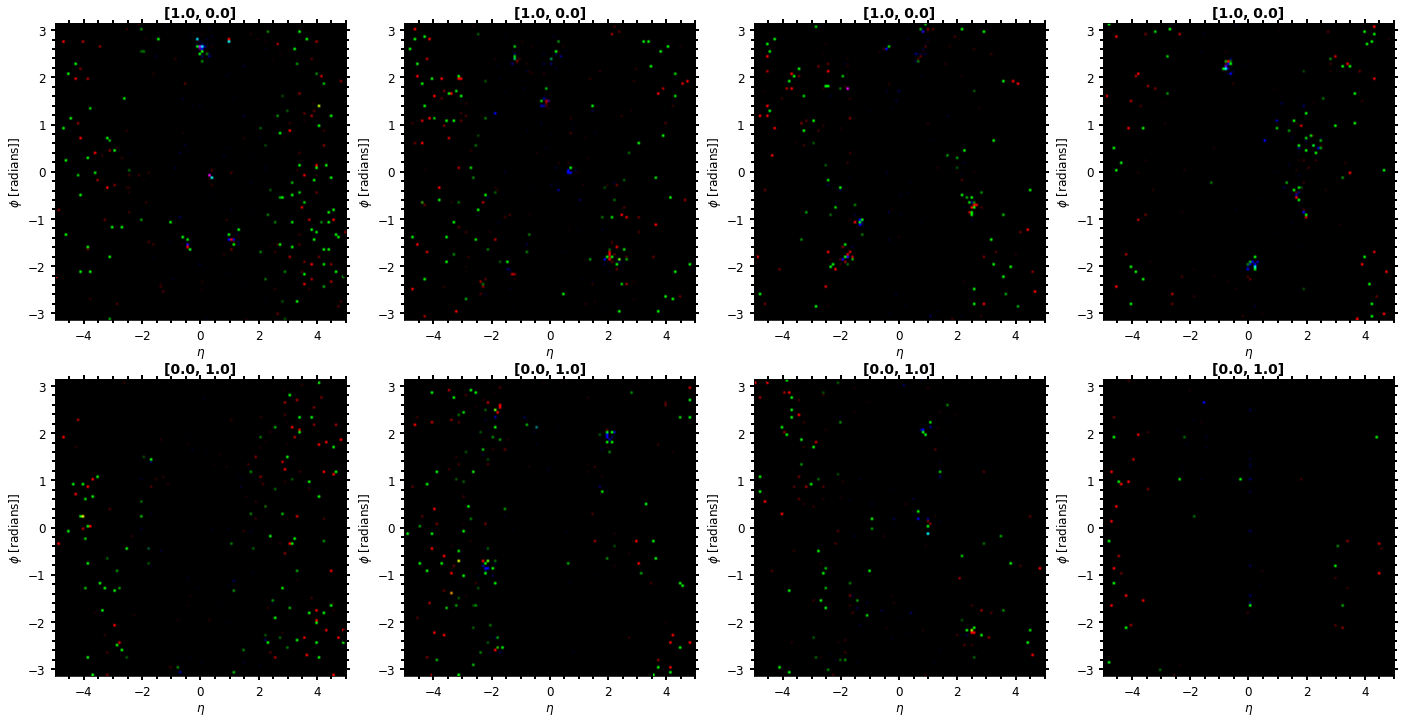

In [6]:
view_data(testdata, 4, CLASSES, N_EVENTS*(VAL_PCT))

### Create the NN and start training

We will now create the neural network architecture and the functions for training and testing our network. This is a convoluted neural network CNN. 


In [7]:
#create NN and test that nothing major is wrong.
from convnet import ConvNet
net = ConvNet(resolution=RES, image_channels=3, num_classes=CLASSES, stride=3)
net.to(device = device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(testimage.view(-1, 3, RES, RES).shape)
print(net(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 120, 120])
torch.Size([1, 3, 120, 120])
tensor([[0.5144, 0.4856]], grad_fn=<SoftmaxBackward0>)


In [8]:
#Set learning rate, optimizer, loss function and start training
training_results = train(net, traindata, testdata, 50, 4, RES, device, optimizer)

100%|██████████| 4/4 [01:54<00:00, 28.62s/it]


### Analyzing our model
Let's take a look at the learning metrics collected in our dataframe. High accuracy on training data and low accuracy on validation implies overtraining. Low accuracy in both categories mean that the network is not learning. Next look at the loss. Loss should go down if the model is learning. If the validation loss starts going up we have overtrained. 

<AxesSubplot:xlabel='Iteration'>

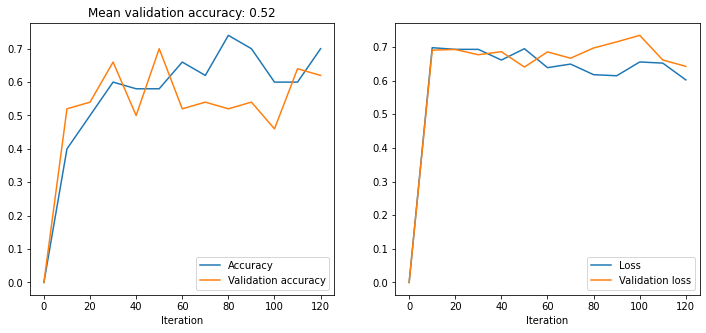

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])

To further analyse our model we can check how the predictions compare to the true values. This can highlight which classes we are having trouble with.

In [10]:
from sklearn.metrics import accuracy_score
truth, preds = predict(net, testdata, 100, RES, device)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

400


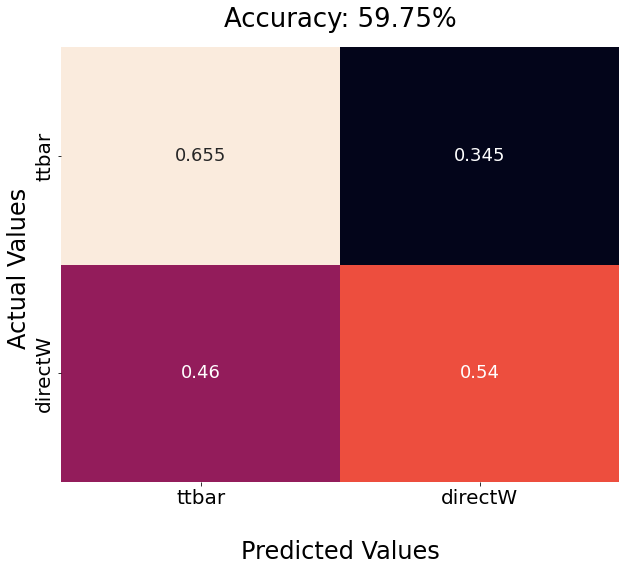

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (10, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 18})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)
ax.set_title(f"Accuracy: {round(accuracy, 4)*100}%", size=26, pad=20)

## Display the visualization of the Confusion Matrix.
plt.show()